In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install simpleitk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 12.0 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import os
import random
import numpy as np
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import SimpleITK as sitk
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, UpSampling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

In [5]:
data_path = "drive/MyDrive/lungs_dataset/subset0/subset0/"
total_imgs_names = next(os.walk(data_path))[2]
print(len(total_imgs_names), total_imgs_names)

178 ['1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.raw', '1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.raw', '1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.raw', '1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.raw', '1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720.raw', '1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781143514.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565.raw', '1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781

In [6]:
masks_path = "drive/MyDrive/lungs_dataset/seg-lungs-LUNA16/"
total_masks_names = next(os.walk(masks_path))[2]
print(len(total_masks_names),total_masks_names)

1776 ['1.3.6.1.4.1.14519.5.2.1.6279.6001.239358021703233250639913775427.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.232058316950007760548968840196.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.235364978775280910367690540811.zraw', '1.3.6.1.4.1.14519.5.2.1.6279.6001.242761658169703141430370511586.zraw', '1.3.6.1.4.1.14519.5.2.1.6279.6001.243094273518213382155770295147.zraw', '1.3.6.1.4.1.14519.5.2.1.6279.6001.233652865358649579816568545171.zraw', '1.3.6.1.4.1.14519.5.2.1.6279.6001.230416590143922549745658357505.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.228511122591230092662900221600.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.224465398054769500989828256685.zraw', '1.3.6.1.4.1.14519.5.2.1.6279.6001.225154811831720426832024114593.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.238522526736091851696274044574.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.227962600322799211676960828223.zraw', '1.3.6.1.4.1.14519.5.2.1.6279.6001.238042459915048190592571019348.zraw', '1.3.6.1.4.1.14519.5.2.1.6279.6001.2374289773113655

In [ ]:

import SimpleITK as sitk
mhd_file_path_mask = "drive/MyDrive/lungs_dataset/seg-lungs-LUNA16/1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.mhd"
itk_mask = sitk.ReadImage(mhd_file_path_mask)
mask_array = sitk.GetArrayFromImage(itk_mask)
mask_array.shape

(194, 512, 512)

In [7]:
common_elements_names = sorted(list(set(total_imgs_names) & set(total_masks_names)))
print(len(common_elements_names), common_elements_names)
total_files_to_use = 7
num_train_files = 5
num_val_files = 1
num_test_files = 1

data_imgs_files = common_elements_names[:total_files_to_use]
data_masks_files = common_elements_names[:total_files_to_use]

data_imgs_files_train = data_imgs_files[:num_train_files]
data_imgs_files_test = data_imgs_files[num_train_files : num_train_files+num_test_files]
data_imgs_files_val = data_imgs_files[num_train_files+num_test_files : num_train_files+num_val_files+num_test_files]

data_masks_files_train = data_masks_files[:num_train_files]
data_masks_files_test = data_masks_files[num_train_files : num_train_files+num_test_files]
data_masks_files_val = data_masks_files[num_train_files+num_test_files : num_train_files+num_val_files+num_test_files]

89 ['1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781143514.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.1380808888433570478112387

In [8]:
index = 0
train_imgs = []
train_masks = []
for i in tqdm(range(num_train_files)):
    mhd_img_file_name = data_imgs_files_train[i]
    mhd_mask_file_name = data_masks_files_train[i]
    
    mhd_file_path_img = "drive/MyDrive/lungs_dataset/subset0/subset0/" + mhd_img_file_name
    mhd_file_path_mask = "drive/MyDrive/lungs_dataset/seg-lungs-LUNA16/" + mhd_mask_file_name
    
    itk_image = sitk.ReadImage(mhd_file_path_img)
    image_array = sitk.GetArrayViewFromImage(itk_image)
    
    itk_mask = sitk.ReadImage(mhd_file_path_mask)
    mask_array = sitk.GetArrayFromImage(itk_mask)

    total_slices = int(len(image_array)*0.5)
    for j in range(total_slices):
      slice = np.copy(image_array[j])
      slice[slice < -1000] = -1000
      slice[slice > 200] = 200
      slice += 1000
      slice = (slice/1200).astype(int)
      slice = slice[..., np.newaxis]
      slice = np.expand_dims(slice, axis=0)
      train_imgs.append(slice)
    
    for j in range(total_slices):
      slice = np.copy(mask_array[j])
      if(np.max(slice)!=0):
        slice = slice/np.max(slice)
      slice = slice[..., np.newaxis]
      slice = np.expand_dims(slice, axis=0)
      train_masks.append(slice)

100%|██████████| 5/5 [00:22<00:00,  4.59s/it]


In [9]:
index = 0
val_imgs = []
val_masks = []
for i in tqdm(range(num_val_files)):
    mhd_img_file_name = data_imgs_files_val[i]
    mhd_mask_file_name = data_masks_files_val[i]
    
    mhd_file_path_img = "drive/MyDrive/lungs_dataset/subset0/subset0/" + mhd_img_file_name
    mhd_file_path_mask = "drive/MyDrive/lungs_dataset/seg-lungs-LUNA16/" + mhd_mask_file_name
    
    itk_image = sitk.ReadImage(mhd_file_path_img)
    image_array = sitk.GetArrayViewFromImage(itk_image)
    
    itk_mask = sitk.ReadImage(mhd_file_path_mask)
    mask_array = sitk.GetArrayFromImage(itk_mask)

    total_slices = int(len(image_array)*0.5)
    for j in range(total_slices):
      slice = np.copy(image_array[j])
      slice[slice < -1000] = -1000
      slice[slice > 200] = 200
      slice += 1000
      slice = (slice/1200).astype(int)
      slice = slice[..., np.newaxis]
      slice = np.expand_dims(slice, axis=0)
      val_imgs.append(slice)
      # break
    
    for j in range(total_slices):
      slice = np.copy(mask_array[j])
      if(np.max(slice)!=0):
        slice = slice/np.max(slice)
      slice = slice[..., np.newaxis]
      slice = np.expand_dims(slice, axis=0)
      val_masks.append(slice)
      # break
    
    # break

100%|██████████| 1/1 [00:03<00:00,  3.71s/it]


In [10]:
index = 0
test_imgs = []
test_masks = []
for i in tqdm(range(num_test_files)):
    mhd_img_file_name = data_imgs_files_test[i]
    mhd_mask_file_name = data_masks_files_test[i]
    
    mhd_file_path_img = "drive/MyDrive/lungs_dataset/subset0/subset0/" + mhd_img_file_name
    mhd_file_path_mask = "drive/MyDrive/lungs_dataset/seg-lungs-LUNA16/" + mhd_mask_file_name
    
    itk_image = sitk.ReadImage(mhd_file_path_img)
    image_array = sitk.GetArrayViewFromImage(itk_image)
    
    itk_mask = sitk.ReadImage(mhd_file_path_mask)
    mask_array = sitk.GetArrayFromImage(itk_mask)

    total_slices = int(len(image_array)*0.5)
    for j in range(total_slices):
      slice = np.copy(image_array[j])
      slice[slice < -1000] = -1000
      slice[slice > 200] = 200
      slice += 1000
      slice = (slice/1200).astype(int)
      slice = slice[..., np.newaxis]
      slice = np.expand_dims(slice, axis=0)
      test_imgs.append(slice)
    
    for j in range(total_slices):
      slice = np.copy(mask_array[j])
      if(np.max(slice)!=0):
        slice = slice/np.max(slice)
      slice = slice[..., np.newaxis]
      slice = np.expand_dims(slice, axis=0)
      test_masks.append(slice)
    

100%|██████████| 1/1 [00:03<00:00,  3.45s/it]


In [ ]:
len(train_masks)

530

In [ ]:
print(len(train_imgs))
print(len(val_imgs))
print(len(test_imgs))

530
66
97


In [11]:
smooth = 1
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [12]:
def unet_model(input_size = (512,512,1), filter_size = [64,128,256,512, 1024], learning_rate=1e-3, kernel_size = 4, loss = 'binary_crossentropy', dropout_val = 0):
    
    inputs = Input(input_size)
    
    #double conv block - 1
    conv1 = Conv2D(filter_size[0], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(filter_size[0], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    
    #downsampling - maxpool - 1
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
    pool1 = Dropout(dropout_val)(pool1)
    
    #double conv block - 2
    conv2 = Conv2D(filter_size[1], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(filter_size[1], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    
    #downsampling - maxpool - 2
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
    pool2 = Dropout(dropout_val)(pool2)

    #double conv block - 3
    conv3 = Conv2D(filter_size[2], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(filter_size[2], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    
    #downsampling - maxpool - 3
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
    pool3 = Dropout(dropout_val)(pool3)

    #double conv block - 4
    conv4 = Conv2D(filter_size[3], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(filter_size[3], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    
    # drop4 = Dropout(0.5)(conv4)
    #downsampling - maxpool - 4
    pool4 = MaxPooling2D(pool_size=(2,2))(conv4)
    pool4 = Dropout(dropout_val)(pool4)
    

    #middle block
    conv5 = Conv2D(filter_size[4], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(filter_size[4], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    # drop5 = Dropout(0.5)(conv5)

    #upsampling block - 1
    up6 = Conv2DTranspose(filter_size[3],2,strides=(2,2),padding='same')(conv5)
    # concat and double conv block - 1
    merge6 = concatenate([conv4,up6], axis = 3)
    merge6 = Dropout(dropout_val)(merge6)
    conv6 = Conv2D(filter_size[3], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(filter_size[3], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    
    #upsampling block - 2
    up7 = Conv2DTranspose(filter_size[2],2,strides=(2,2),padding='same')(conv6)
    # concat and double conv block - 2
    merge7 = concatenate([conv3,up7], axis = 3)
    merge7 = Dropout(dropout_val)(merge7)
    conv7 = Conv2D(filter_size[2], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(filter_size[2], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    #upsampling block - 3
    up8 = Conv2DTranspose(filter_size[1],2,strides=(2,2),padding='same')(conv7)
    #concat and double conv block - 3
    merge8 = concatenate([conv2,up8], axis = 3)
    merge8 = Dropout(dropout_val)(merge8)
    conv8 = Conv2D(filter_size[1], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(filter_size[1], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    #upsampling block - 4
    up9 = Conv2DTranspose(filter_size[0],2,strides=(2,2),padding='same')(conv8)
    #concat and double conv block - 4
    merge9 = concatenate([conv1,up9], axis = 3)
    merge9 = Dropout(dropout_val)(merge9)
    conv9 = Conv2D(filter_size[0], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(filter_size[0], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    # end layers 
    conv9 = Conv2D(2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    if(loss == 'dice_loss'):
      conv10 = Conv2D(1,1,activation = 'tanh')(conv9)
    else:
      conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    if(loss == 'binary_crossentropy'):
      model.compile(optimizer = Adam(lr = learning_rate), loss='binary_crossentropy', metrics=[dice_coef])
    elif(loss == 'ssim'):
      model.compile(optimizer = Adam(lr = learning_rate), loss=SSIMLoss, metrics=[dice_coef])
    elif(loss =='dice_loss'):
      model.compile(optimizer = Adam(lr = learning_rate), loss=dice_coef_loss, metrics=[dice_coef])

    model.summary()
    return model

    
    
    
    

In [ ]:
def unet_model2(input_size = (512,512,1), filter_size = [64,128,256,512], learning_rate=1e-3, kernel_size = 3):
    
    inputs = Input(input_size)
    
    #double conv block - 1
    conv1 = Conv2D(filter_size[0], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(filter_size[0], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    
    #downsampling - maxpool - 1
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
    
    #double conv block - 2
    conv2 = Conv2D(filter_size[1], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(filter_size[1], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    
    #downsampling - maxpool - 2
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    #double conv block - 3
    conv3 = Conv2D(filter_size[2], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(filter_size[2], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    
    #downsampling - maxpool - 3
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

    #double conv block - 4
    conv4 = Conv2D(filter_size[3], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(filter_size[3], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    

    #upsampling block - 1
    up6 = Conv2DTranspose(filter_size[2],2,strides=(2,2),padding='same')(conv4)
    # concat and double conv block - 1
    merge6 = concatenate([conv3,up6], axis = 3)
    conv6 = Conv2D(filter_size[2], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(filter_size[2], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    
    #upsampling block - 2
    up7 = Conv2DTranspose(filter_size[1],2,strides=(2,2),padding='same')(conv6)
    # concat and double conv block - 2
    merge7 = concatenate([conv2,up7], axis = 3)
    conv7 = Conv2D(filter_size[1], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(filter_size[1], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    #upsampling block - 3
    up8 = Conv2DTranspose(filter_size[0],2,strides=(2,2),padding='same')(conv7)
    #concat and double conv block - 3
    merge8 = concatenate([conv1,up8], axis = 3)
    conv8 = Conv2D(filter_size[0], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(filter_size[0], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    # end layers 
    conv9 = Conv2D(2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(lr = learning_rate), loss='binary_crossentropy', metrics=[dice_coef])

    model.summary()
    return model

    
    
    
    

In [ ]:
def unet_model3(input_size = (512,512,1), filter_size = [32,64,128,256,512,1024], learning_rate=1e-3, kernel_size = 3):
    
    inputs = Input(input_size)
    
    #double conv block - 1
    conv1 = Conv2D(filter_size[0], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(filter_size[0], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    
    #downsampling - maxpool - 1
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
    
    #double conv block - 2
    conv2 = Conv2D(filter_size[1], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(filter_size[1], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    
    #downsampling - maxpool - 2
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    #double conv block - 3
    conv3 = Conv2D(filter_size[2], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(filter_size[2], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    
    #downsampling - maxpool - 3
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

    #double conv block - 4
    conv4 = Conv2D(filter_size[3], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(filter_size[3], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    
    # drop4 = Dropout(0.5)(conv4)
    #downsampling - maxpool - 4
    pool4 = MaxPooling2D(pool_size=(2,2))(conv4)
    

    #double conv block - 5
    conv5 = Conv2D(filter_size[4], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(filter_size[4], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  
    #downsampling - maxpool - 4
    pool5 = MaxPooling2D(pool_size=(2,2))(conv5)
    # drop5 = Dropout(0.5)(conv5)

    #double conv block - 6
    conv6 = Conv2D(filter_size[5], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool5)
    conv6 = Conv2D(filter_size[5], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    #upsampling block - 1
    up7 = Conv2DTranspose(filter_size[4],2,strides=(2,2),padding='same')(conv6)
    # concat and double conv block - 1
    merge7 = concatenate([conv5,up7], axis = 3)
    conv7 = Conv2D(filter_size[4], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(filter_size[4], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    
    #upsampling block - 2
    up8 = Conv2DTranspose(filter_size[3],2,strides=(2,2),padding='same')(conv7)
    # concat and double conv block - 2
    merge8 = concatenate([conv4,up8], axis = 3)
    conv8 = Conv2D(filter_size[3], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(filter_size[3], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    #upsampling block - 3
    up9 = Conv2DTranspose(filter_size[2],2,strides=(2,2),padding='same')(conv8)
    #concat and double conv block - 3
    merge9 = concatenate([conv3,up9], axis = 3)
    conv9 = Conv2D(filter_size[2], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(filter_size[2], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    #upsampling block - 4
    up10 = Conv2DTranspose(filter_size[1],2,strides=(2,2),padding='same')(conv9)
    #concat and double conv block - 4
    merge10 = concatenate([conv2,up10], axis = 3)
    conv10 = Conv2D(filter_size[1], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge10)
    conv10 = Conv2D(filter_size[1], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv10)

    #upsampling block - 5
    up11 = Conv2DTranspose(filter_size[0],2,strides=(2,2),padding='same')(conv10)
    #concat and double conv block - 4
    merge11 = concatenate([conv1,up11], axis = 3)
    conv11 = Conv2D(filter_size[0], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge11)
    conv11 = Conv2D(filter_size[0], kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)

    # end layers 
    conv11 = Conv2D(2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
    conv12 = Conv2D(1, 1, activation = 'sigmoid')(conv11)

    model = Model(inputs, conv12)

    model.compile(optimizer = Adam(lr = learning_rate), loss='binary_crossentropy', metrics=[dice_coef])

    model.summary()
    return model

    
    
    
    

In [13]:
tf.debugging.set_log_device_placement(True)

In [14]:
model = unet_model(filter_size = [32,64,128,256,512], learning_rate = 1e-3, kernel_size = 3, dropout_val = 0)
# model = unet_model2(filter_size = [32,64,128,256], learning_rate = 1e-3, kernel_size = 3)
# model = unet_model3()

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessTruncatedNormalV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _Eag

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job

In [ ]:
# print ("number of training examples = " + str(train_imgs[0]))
# print ("number of development examples = " + str(val_imgs.shape[0]))
# print ("number of test examples = " + str(test_imgs.shape[0]))
# print ("Images_train shape: " + str(train_imgs.shape))
# print ("Masks_train shape: " + str(train_masks.shape))
# print ("Images_val (dev) shape: " + str(val_imgs.shape))
# print ("Masks_val (dev) shape: " + str(val_masks.shape))
# print ("Images_test shape: " + str(test_imgs.shape))
# print ("Masks_test shape: " + str(test_masks.shape))
     

In [15]:
np_train_imgs = np.vstack(train_imgs)
np_val_imgs = np.vstack(val_imgs)
np_test_imgs = np.vstack(test_imgs)

np_train_masks = np.vstack(train_masks)
np_val_masks = np.vstack(val_masks)
np_test_masks = np.vstack(test_masks)

print(np_train_imgs.shape)
print(np_val_imgs.shape)
print(np_test_imgs.shape)

print(np_train_masks.shape)
print(np_val_masks.shape)
print(np_test_masks.shape)

(530, 512, 512, 1)
(66, 512, 512, 1)
(97, 512, 512, 1)
(530, 512, 512, 1)
(66, 512, 512, 1)
(97, 512, 512, 1)


In [16]:
history = model.fit(np_train_imgs, np_train_masks, batch_size=2, epochs=10, verbose=1,validation_data=(np_val_imgs, np_val_masks))

Streaming output truncated to the last 5000 lines.
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_5322 in device /job:localhost/replica:0/task:0/device:GPU:0
201/265 [=====================>........] - ETA: 10s - loss: 0.0885 - dice_coef: 0.6597Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_5322 in device /job:localhost/replica:0/task:0/device:GPU:0
202/265 [=====================>........] - ETA: 10s - loss: 0.0887 - dice_coef: 0.6588Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_5322 in device /job:localhost/replica:0/task:0/device:GPU:0
203/265 [=====================>........] - ETA: 10s - loss: 0.0884 - dice_coef: 

In [ ]:
np_test_imgs.shape

(97, 512, 512, 1)

In [ ]:
len(np_test_imgs[0:1,:])

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

<ipython-input-17-e992d4b9a44d>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(i+1)


Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

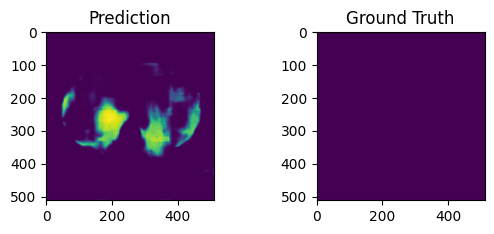

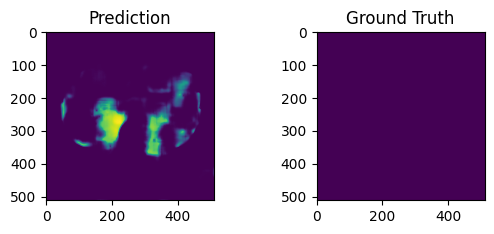

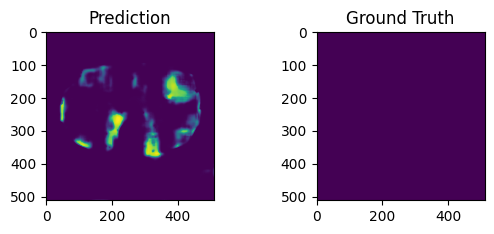

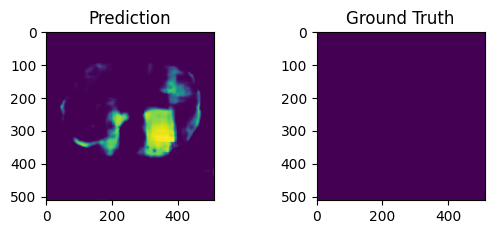

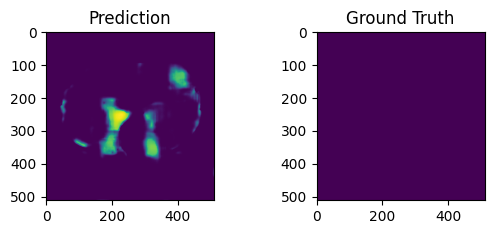

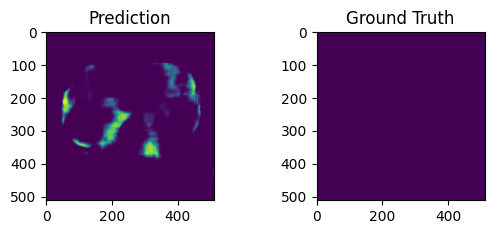

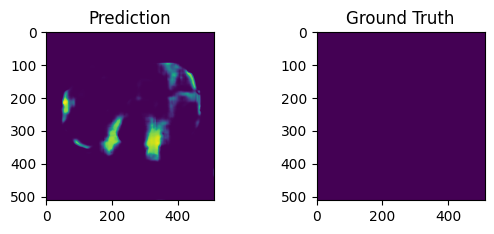

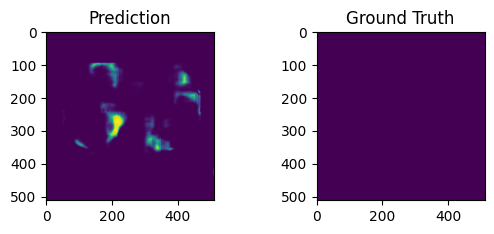

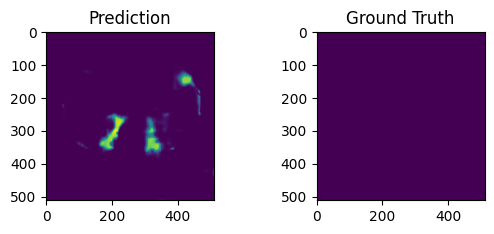

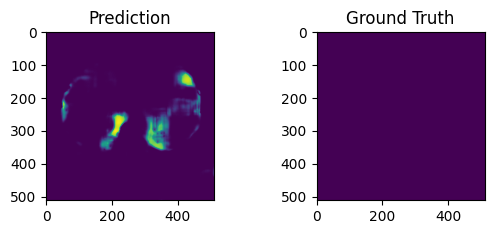

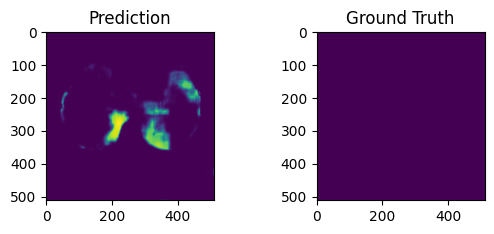

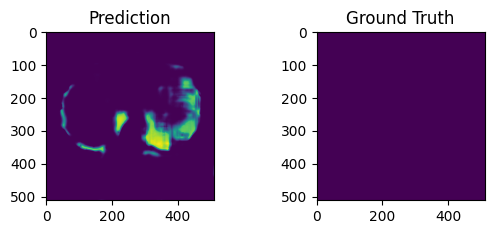

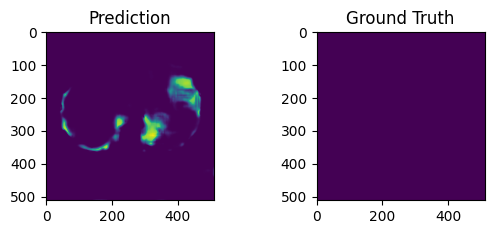

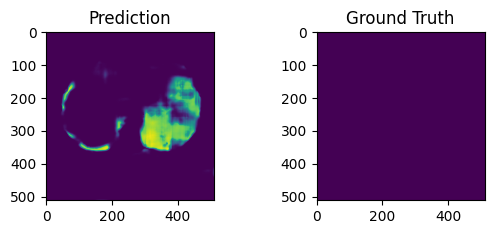

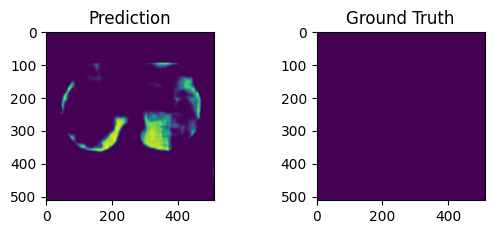

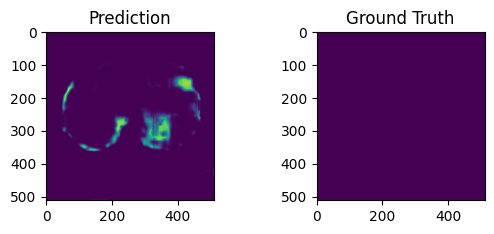

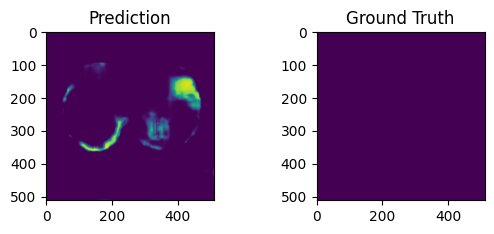

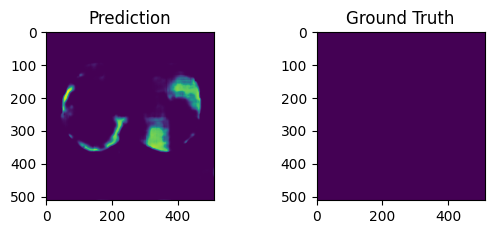

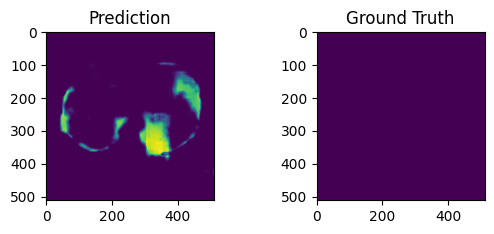

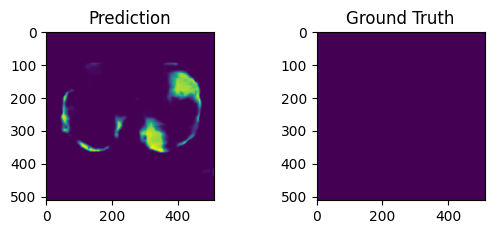

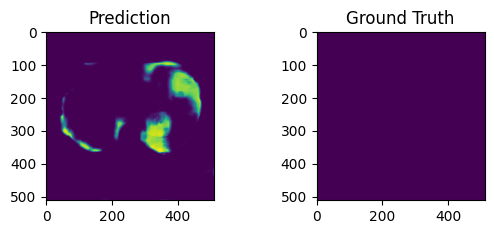

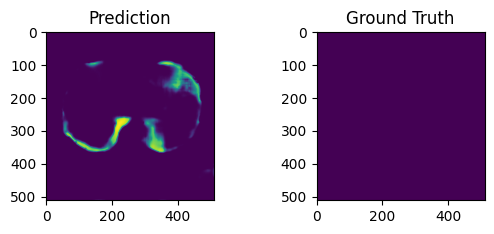

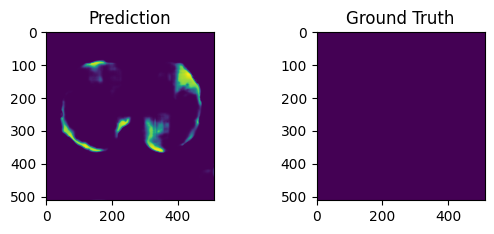

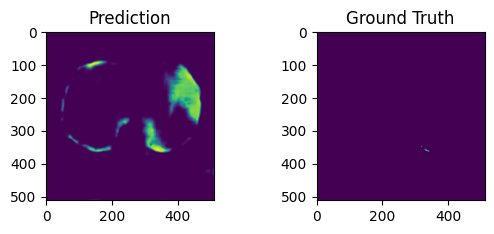

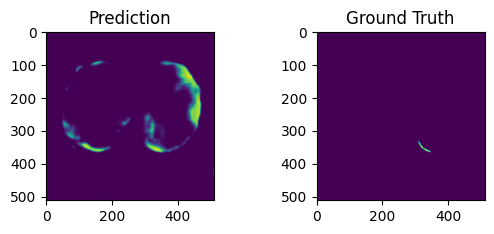

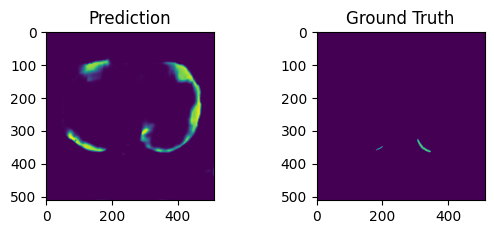

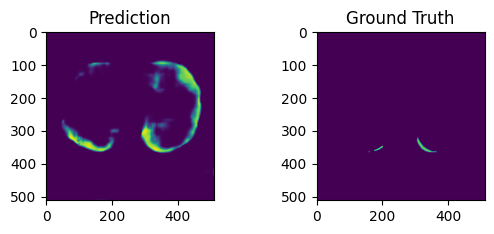

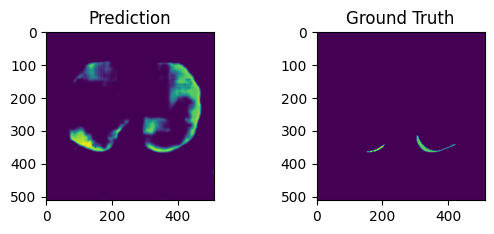

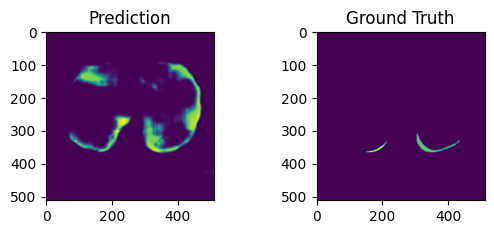

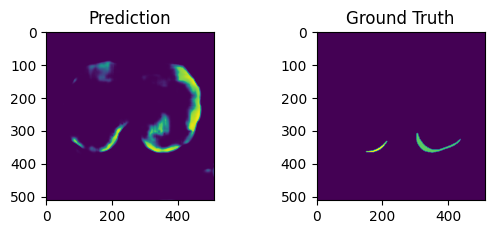

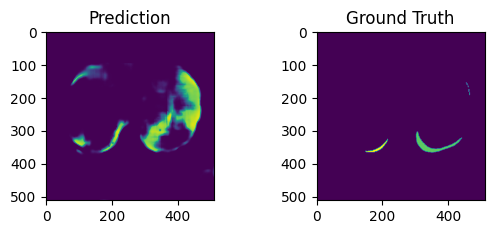

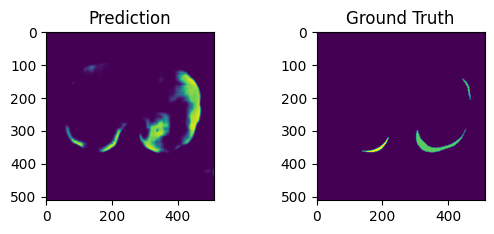

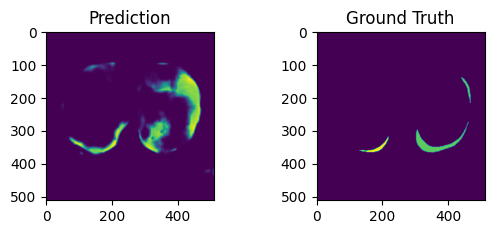

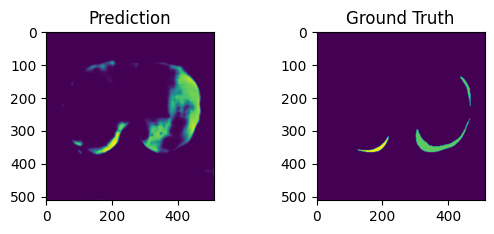

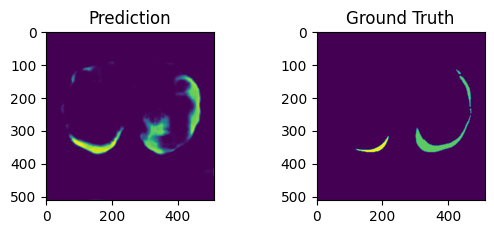

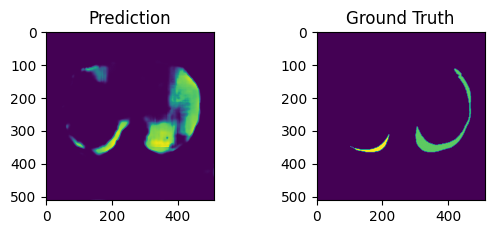

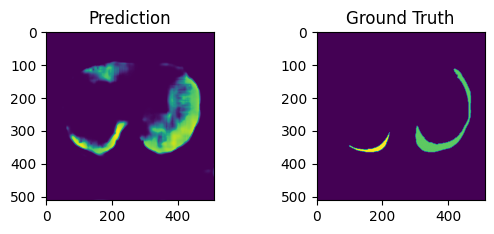

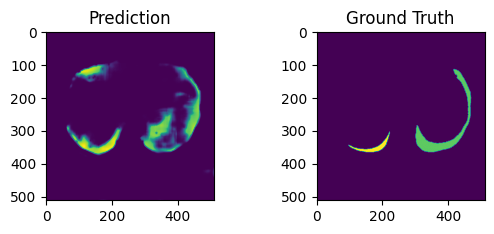

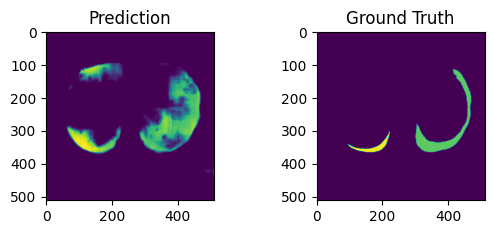

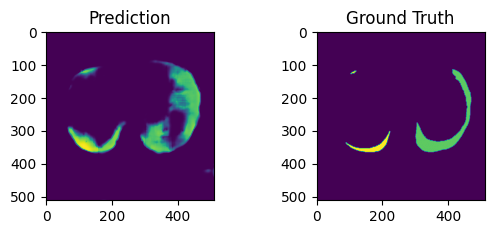

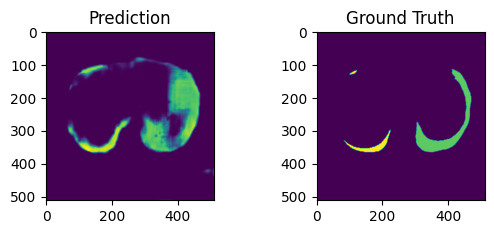

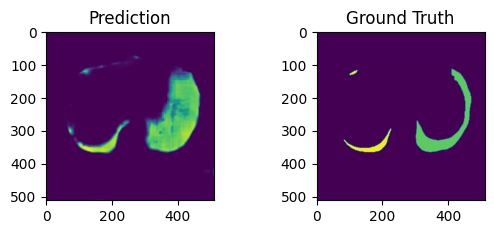

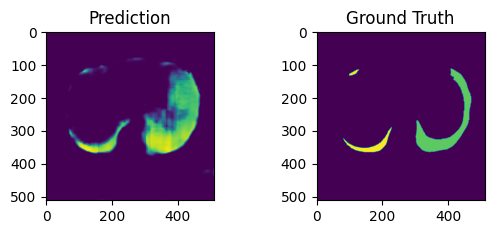

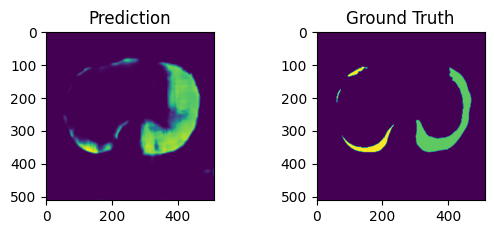

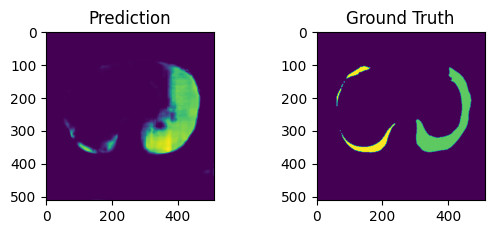

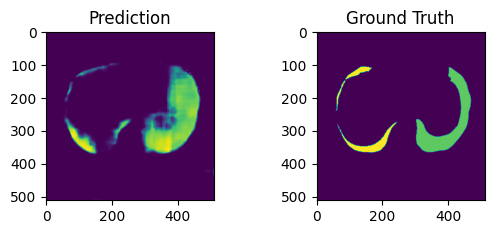

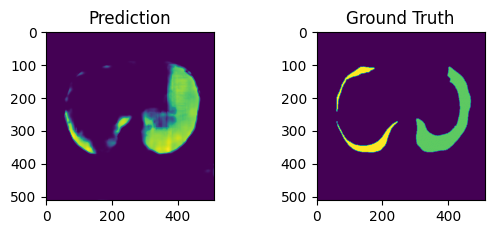

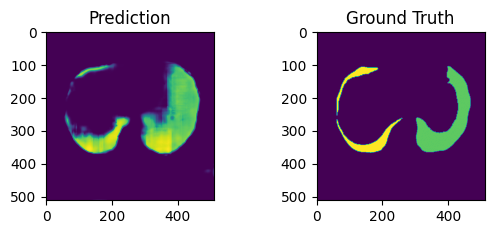

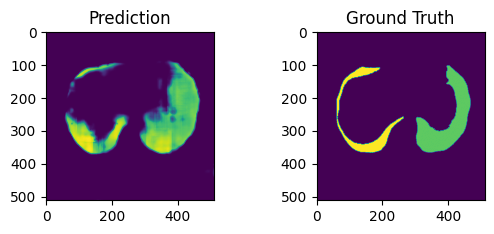

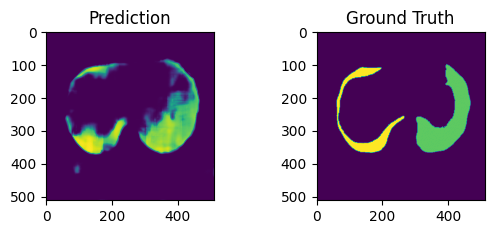

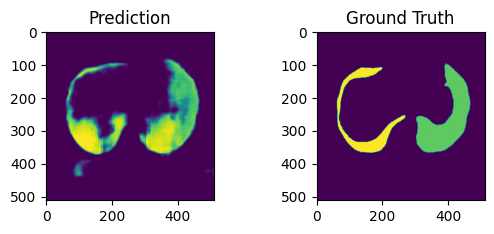

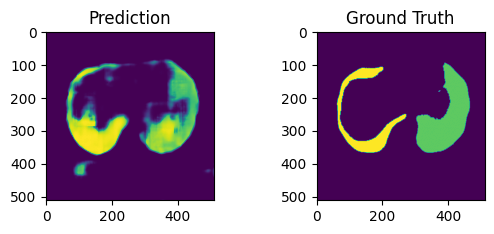

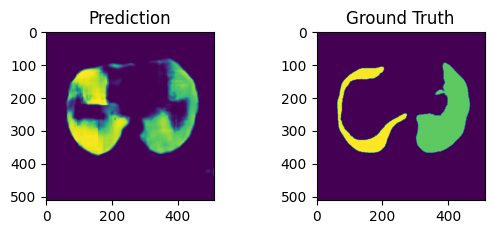

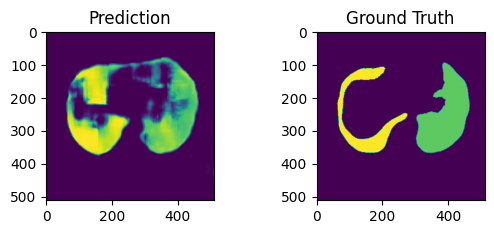

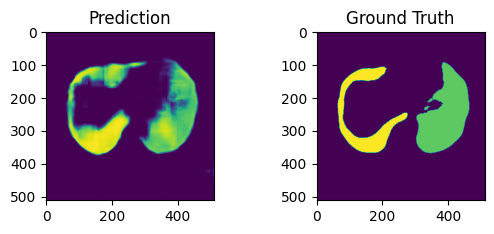

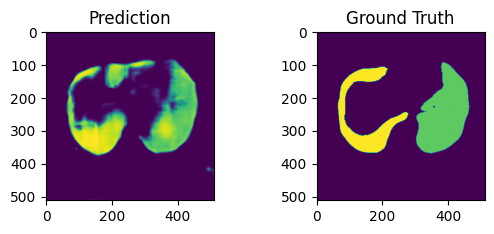

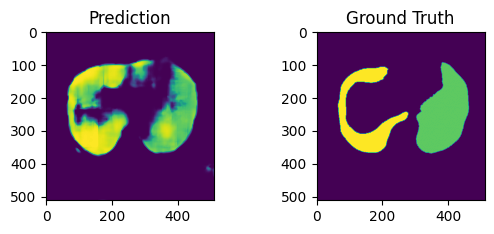

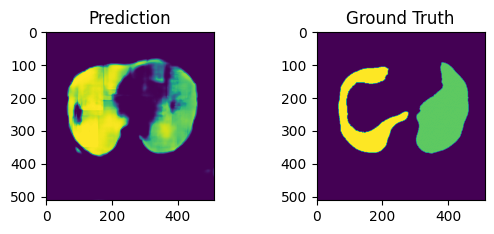

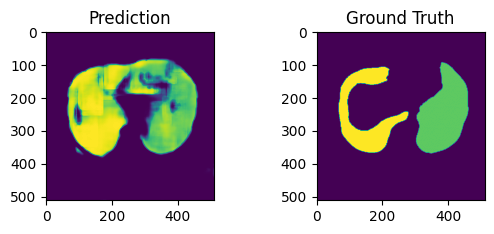

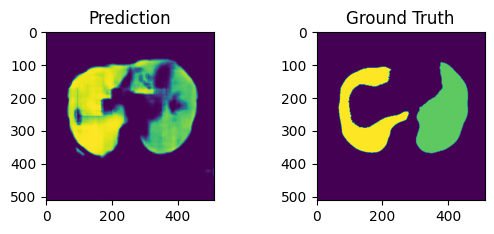

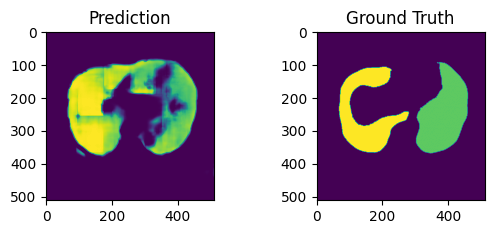

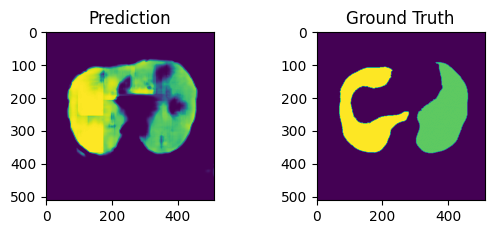

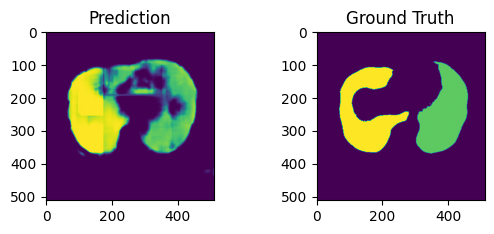

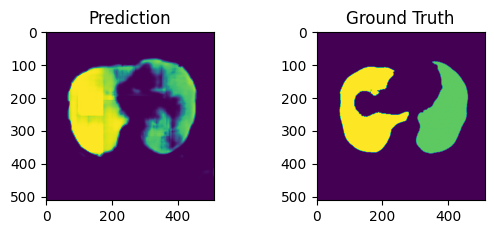

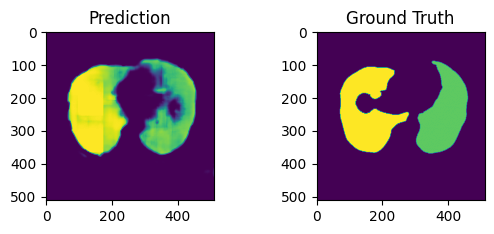

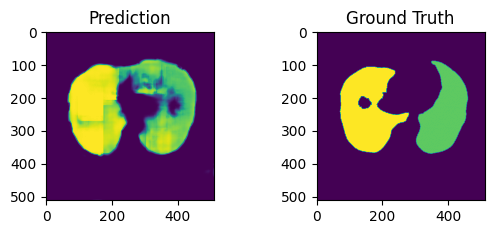

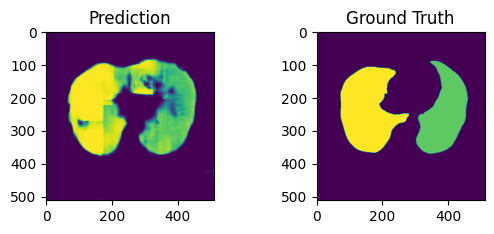

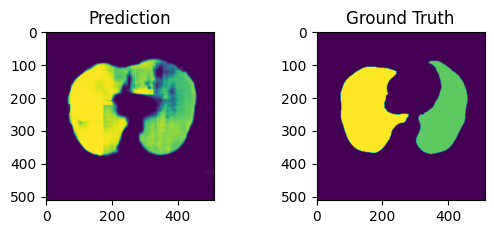

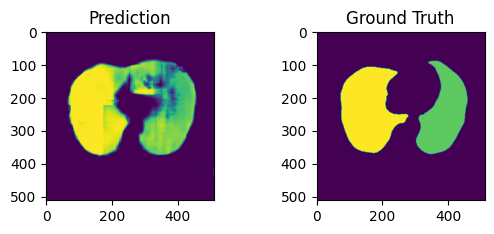

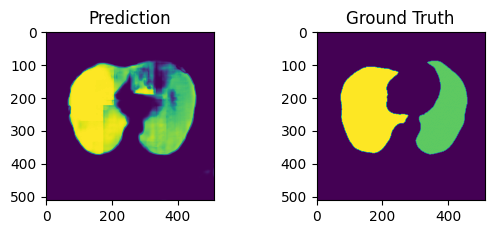

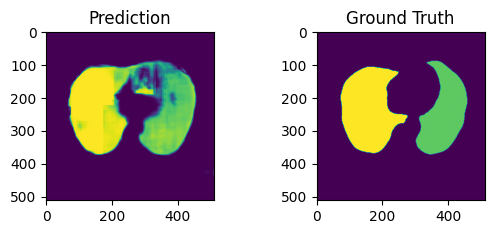

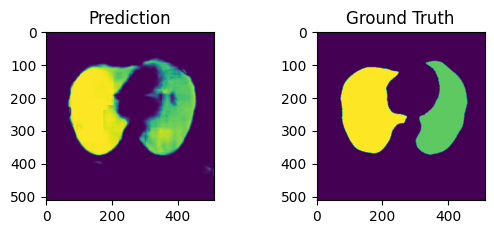

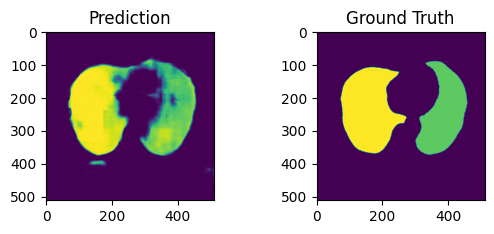

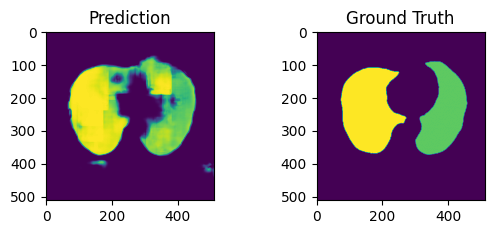

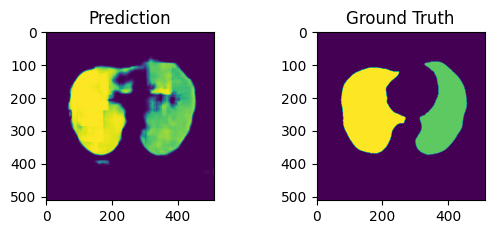

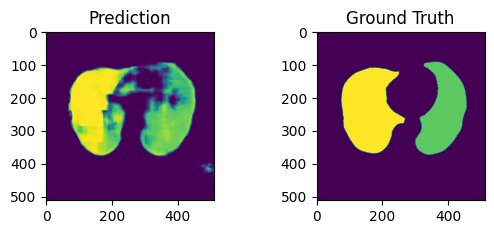

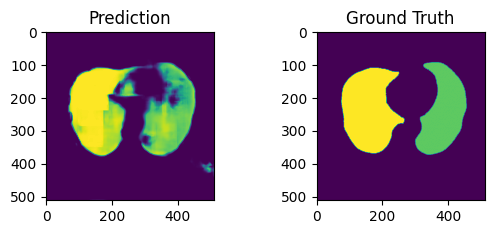

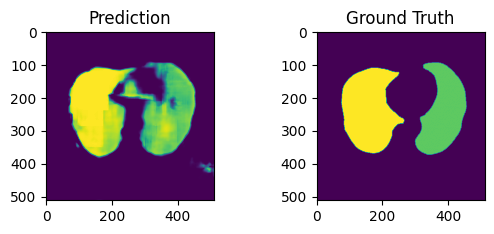

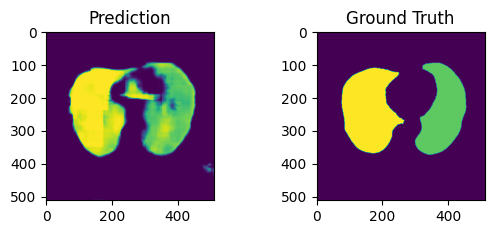

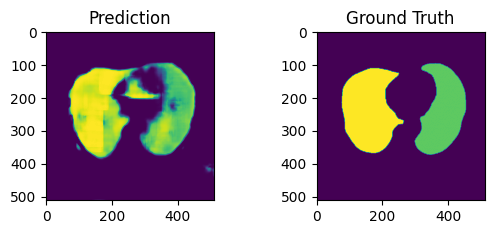

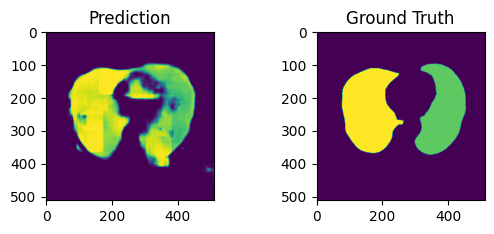

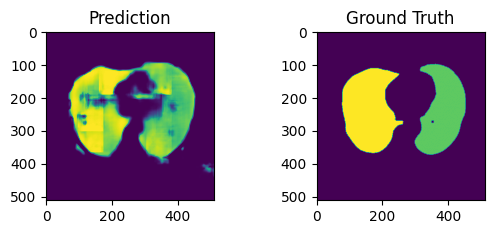

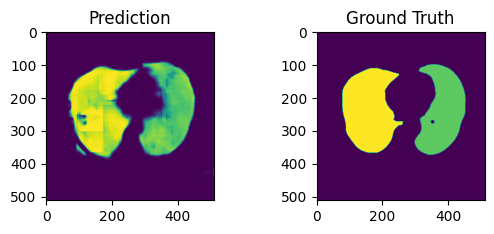

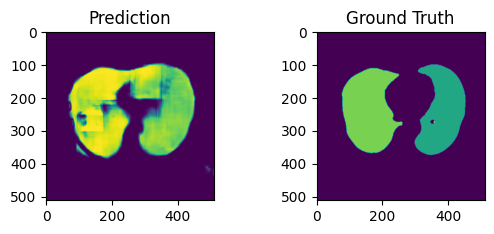

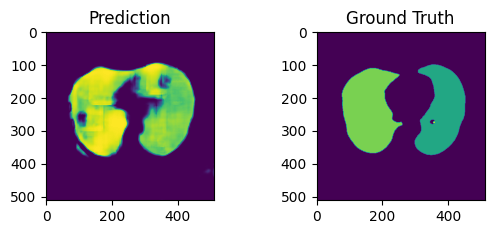

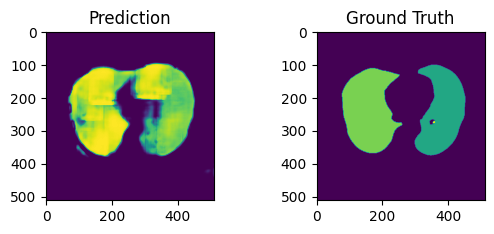

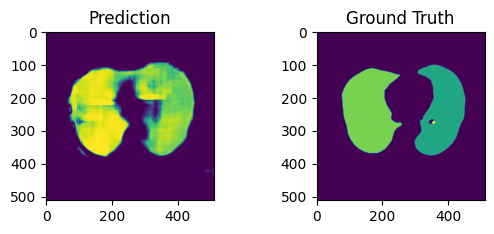

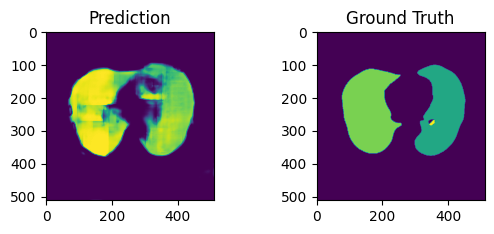

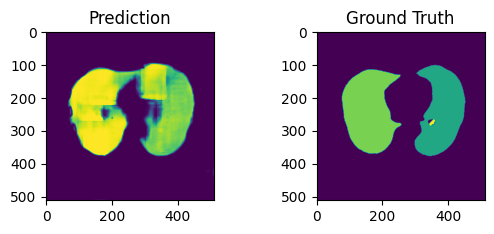

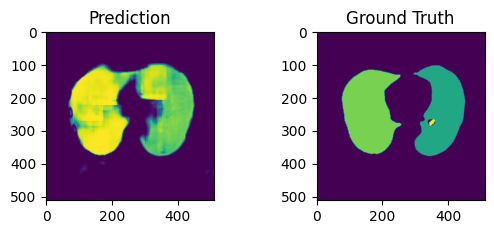

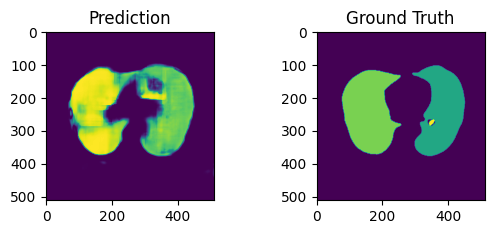

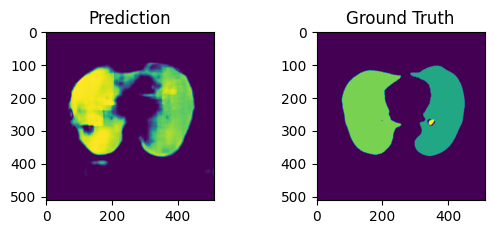

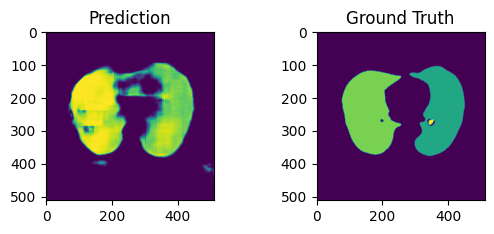

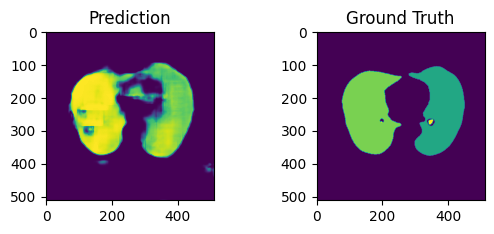

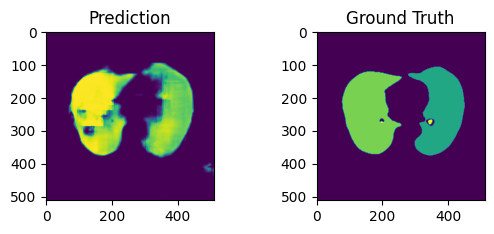

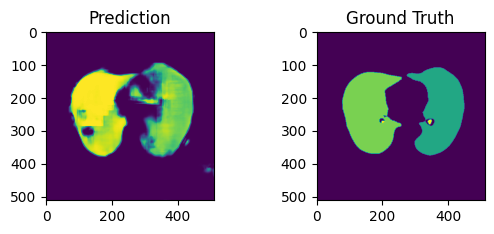

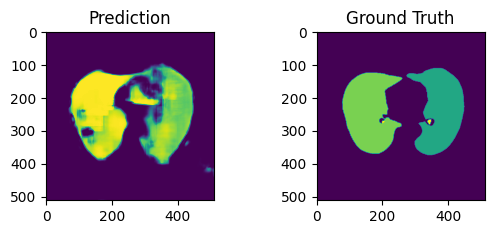

In [17]:
for i in range(len(np_test_imgs)):
  predictions = model.predict(np_test_imgs[i:i+1,:])
  # dice_val = dice_coef(np_test_masks[i], predictions)
  # print(predictions)
  plt.figure(i+1)
  plt.subplot(221)
  plt.title('Prediction')
  plt.imshow(predictions[0,:,:,0])
  plt.subplot(222)
  plt.title('Ground Truth')
  plt.imshow(np_test_masks[i,:,:,0])


In [18]:
test_dice_coeff = model.evaluate(np_test_imgs, np_test_masks)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Opt

In [19]:
model.save("drive/MyDrive/lungs_dataset/best_mode.h5")

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

In [20]:
print("Test Dice Coeff: ", test_dice_coeff[1])

Test Dice Coeff:  0.5176374316215515


In [21]:
train_loss, train_dice_coef, val_loss, val_dice_coef = history.history['loss'], history.history['dice_coef'], history.history['val_loss'], history.history['val_dice_coef']

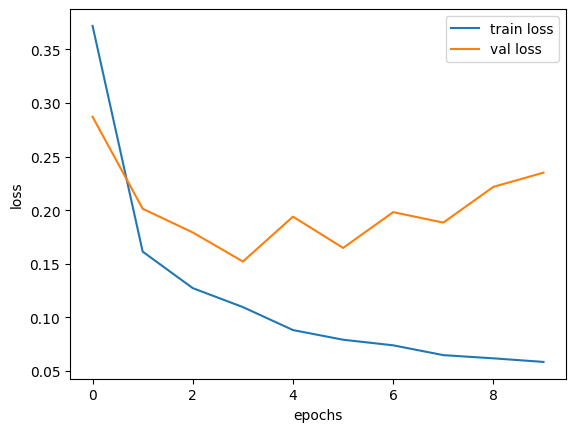

In [22]:
epochs_list = [i for i in range(10)]
plt.plot(epochs_list, train_loss)
plt.plot(epochs_list, val_loss)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["train loss", "val loss"])

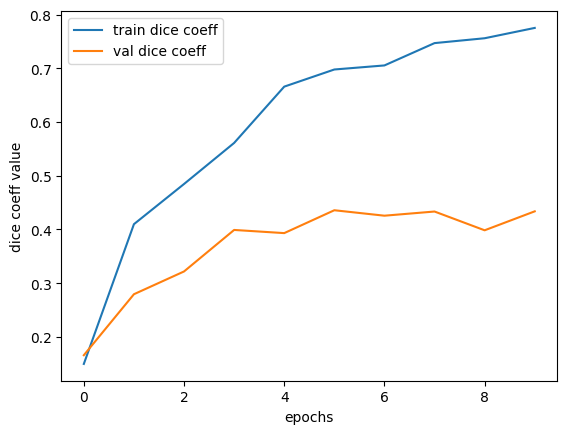

In [23]:
plt.plot(epochs_list, train_dice_coef)
plt.plot(epochs_list, val_dice_coef)
plt.xlabel("epochs")
plt.ylabel("dice coeff value")
plt.legend(["train dice coeff", "val dice coeff"])

In [ ]:
model.metrics